In [ ]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and you are tasked with **predicting the department-wide sales for each store**.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. **The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.**

## Data prep

In [ ]:
# Reading the data using pandas dataframe
features_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
train_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
stores_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
test_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission_df = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

In [ ]:
train_df.head(1)

In [ ]:
stores_df.head(1)

In [ ]:
features_df.head(1)

Let's concat everything in one dataset in order to help with the feature engineering

In [ ]:
df = pd.concat([train_df, test_df])
df['dataset'] = 'train'
df.loc[df['Weekly_Sales'].isnull(), 'dataset'] = 'test'
df.head()

Let's join the other information and get rid of columns we shall not use for now

In [ ]:
df = df.merge(stores_df, on='Store')
df = df.merge(features_df, on=['Store', 'Date'])
df = df.drop(['IsHoliday_y'], axis=1).rename({'IsHoliday_x': 'IsHoliday'}, axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)
df = df.sort_values(by=['Store', 'Dept', 'Date'])
df.head()

By inspecting the sales times series, it's clear that the different types of holidays cause distinct effects in the sales. It can be useful to add a feature to identify each type of holiday.

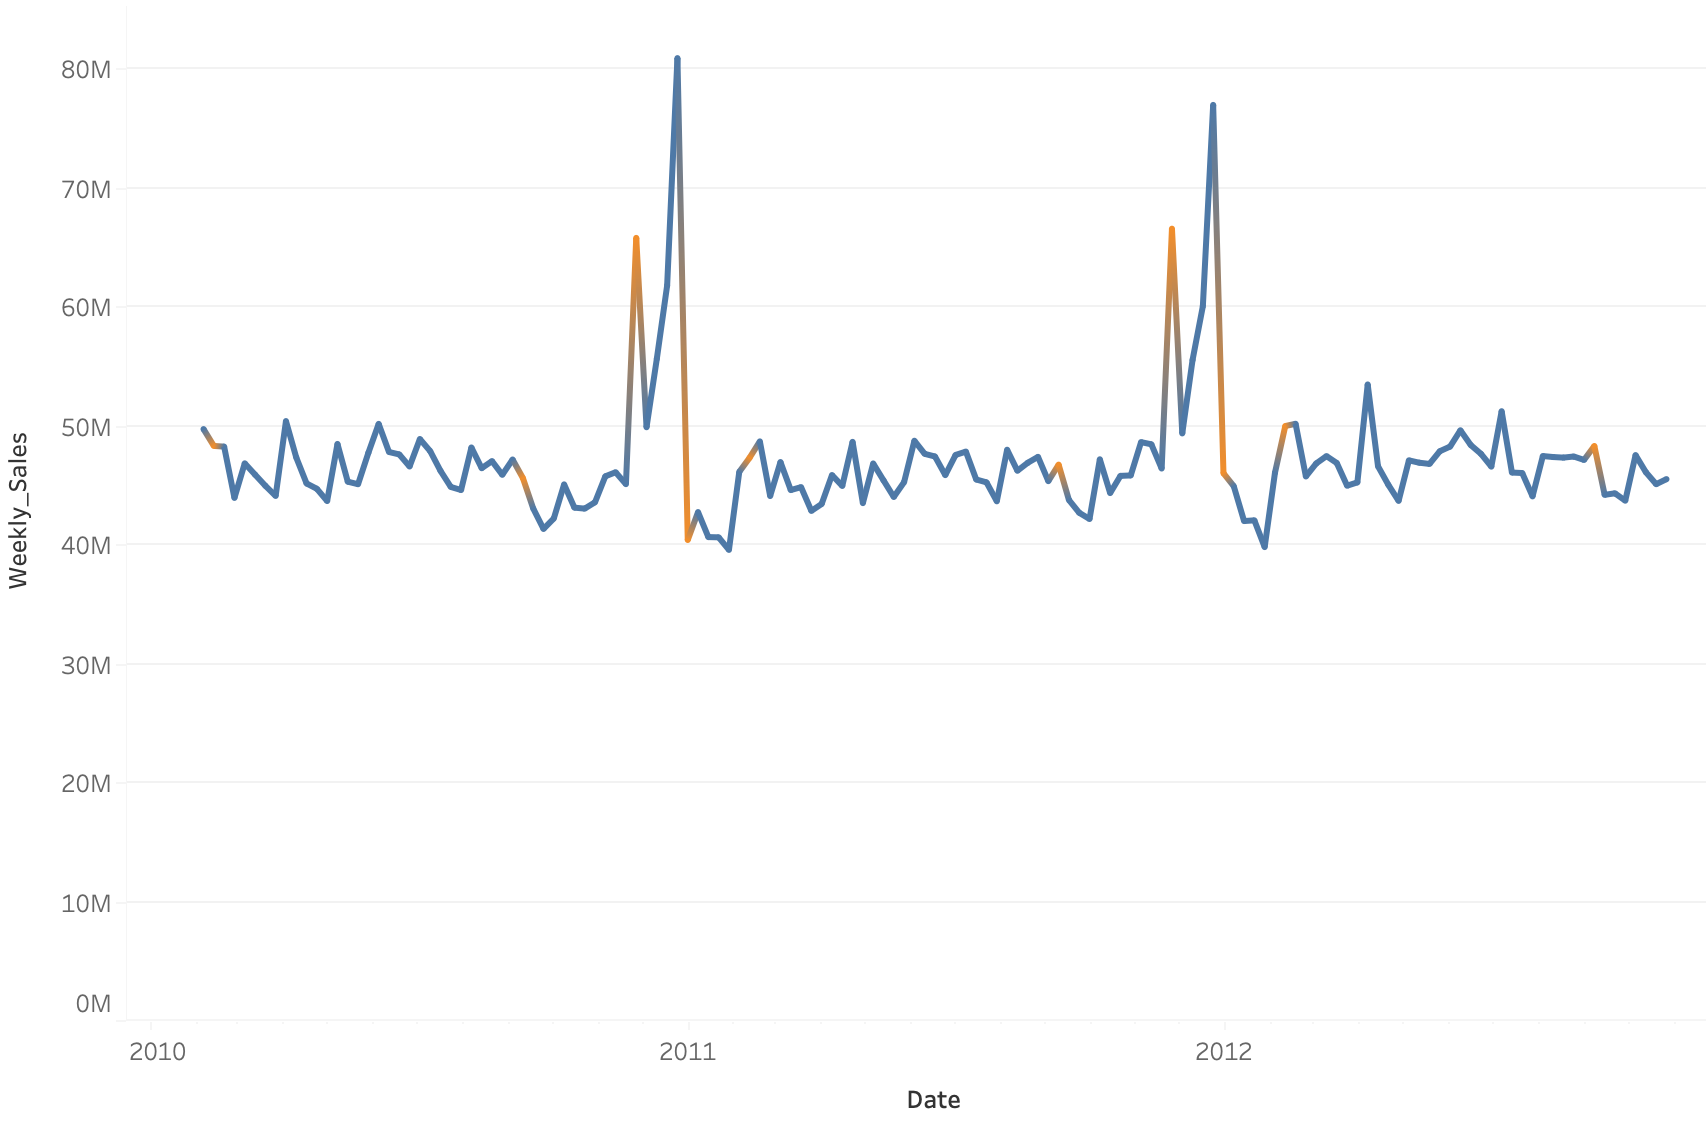

In [ ]:
df['isSuperBowl'] = 0
df.loc[df['Date'] == '2010-02-12', 'isSuperBowl'] = 1
df.loc[df['Date'] == '2011-02-11', 'isSuperBowl'] = 1
df.loc[df['Date'] == '2012-02-10', 'isSuperBowl'] = 1
df.loc[df['Date'] == '2013-02-08', 'isSuperBowl'] = 1

df['isLaborDay'] = 0
df.loc[df['Date'] == '2010-09-10', 'isLaborDay'] = 1
df.loc[df['Date'] == '2011-09-09', 'isLaborDay'] = 1
df.loc[df['Date'] == '2012-09-07', 'isLaborDay'] = 1
df.loc[df['Date'] == '2013-09-06', 'isLaborDay'] = 1

df['isThanksGiving'] = 0
df.loc[df['Date'] == '2010-11-26', 'isThanksGiving'] = 1
df.loc[df['Date'] == '2011-11-25', 'isThanksGiving'] = 1
df.loc[df['Date'] == '2012-11-23', 'isThanksGiving'] = 1
df.loc[df['Date'] == '2013-11-29', 'isThanksGiving'] = 1

df['isChristmas'] = 0
df.loc[df['Date'] == '2010-12-31', 'isChristmas'] = 1
df.loc[df['Date'] == '2011-12-30', 'isChristmas'] = 1
df.loc[df['Date'] == '2012-12-28', 'isChristmas'] = 1
df.loc[df['Date'] == '2013-12-27', 'isChristmas'] = 1

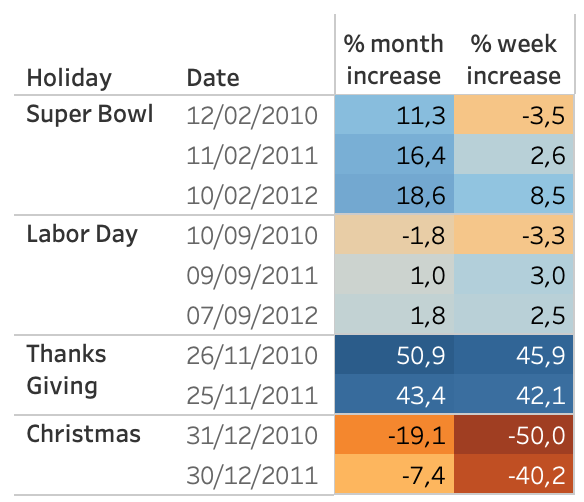

We can also add the last week sales information for each store to help us establishing the baseline

In [ ]:
df['Weekly_Sales_Last_Week'] = df['Weekly_Sales'].shift(1)

In [ ]:
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Week'] = pd.to_datetime(df['Date']).dt.week

## Baseline model

Let's create a baseline model to evaluate our error metric.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

The baseline model will repeat the last week sales

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(17, 4))

ts_df = df[(df['Store'] == 1) & (df['Dept'] == 1) & (df['dataset'] == 'train')]

ts = ts_df[['Date', 'Weekly_Sales']].set_index('Date')
weeks_train = 100

train = ts[0:weeks_train] 
val = ts[weeks_train:] 

train.rename(columns={'Weekly_Sales': 'Train'}).plot(ax=ax)
val.rename(columns={'Weekly_Sales': 'Validation'}).plot(ax=ax)

y_hat_naive = ts_df[['Date', 'Weekly_Sales_Last_Week']].set_index('Date')[weeks_train:]
y_hat_naive.rename(columns={'Weekly_Sales_Last_Week': 'Naive'}).plot(ax=ax)

### Supervised model

For that problem I'll follow a supervised approach instead of a classical time series one. 

In [ ]:
from xgboost import XGBRegressor

I'll use the new holiday dimensions instead of the generic one.

In [ ]:
features = ['Week', 'Year', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'isSuperBowl', 'isLaborDay', 'isThanksGiving', 'isChristmas']

In [ ]:
_df = ts_df[features + ['Weekly_Sales']].dropna(subset=['Weekly_Sales'])
X, y = _df.drop('Weekly_Sales', axis=1), _df['Weekly_Sales']
X_train, y_train, X_val, y_val = X[0:weeks_train], y[0:weeks_train], X[weeks_train:], y[weeks_train:]

In [ ]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)
model.fit(X_train, y_train)

In [ ]:
y_hat_xgb = model.predict(X_val)

In [ ]:
results = pd.DataFrame(
    {'Method':['Naive method', 'XGBRegressor'], 
     'MAE': [
         mean_absolute_error(val, y_hat_naive), 
         mean_absolute_error(y_val, y_hat_xgb), 
     ]})
results = results[['Method', 'MAE']]
results

We can see that for this customer we managed to get a better result with our supervised regressor than the baseline. Is it the case for the other store-departments?

### Regression for all (actually only 50 store-dept to speed things up)

In [ ]:
df['dataset2'] = df['dataset'].copy()
df['Weekly_Sales_predict'] = np.nan

In [ ]:
perf_data = []

for (idx, row) in df[['Store', 'Dept']].drop_duplicates().sample(n=50).iterrows():
    store, dept = row
    print ('Store: {} - Dept: {}'.format(store, dept))
        
    # Filter the data for the store-dept tuple
    customer_dept_df = df[(df['Store'] == store) & (df['Dept'] == dept)]

    # Select only the training data
    ts_df = customer_dept_df[customer_dept_df['dataset'] == 'train']
    weeks_train = 100
    
    # Let's skip low samples time series for now
    if ts_df.index.size*.8 < 100:
        print ("Won't handle low samples ts for now")
        continue

    # Run the naive baseline model
    ts = ts_df[['Date', 'Weekly_Sales']].set_index('Date')
    train = ts[0:weeks_train] 
    val = ts[weeks_train:] 
    y_hat_naive = ts_df[['Date', 'Weekly_Sales_Last_Week']].set_index('Date')[weeks_train:]

    # Run the XGBoost regressor
    _df = ts_df[features + ['Weekly_Sales']]
    X, y = _df.drop('Weekly_Sales', axis=1), _df['Weekly_Sales']
    X_train, y_train, X_val, y_val = X[0:weeks_train], y[0:weeks_train], X[weeks_train:], y[weeks_train:]

    model = XGBRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_hat_xgb = model.predict(X_val)
    
    # Assign the validation data to the dataset in order to help the plot
    df.loc[X_val.index, 'dataset2'] = 'validation'
    df.loc[X_val.index, 'Weekly_Sales_predict'] = model.predict(X_val)

    # Add performance data
    perf_data.append([store, dept, 'Naive', mean_absolute_error(val, y_hat_naive)]) 
    perf_data.append([store, dept, 'XGB', mean_absolute_error(y_val, y_hat_xgb)]) 

    # Train the model in the whole store-dept data and predict the test data
    model.fit(X, y)

    X_test = customer_dept_df[customer_dept_df['dataset'] == 'test'][features]

    df.loc[(df['Store'] == store) & (df['Dept'] == dept) & (df['dataset'] == 'test'), 'Weekly_Sales'] = model.predict(X_test)

In [ ]:
perf_df = pd.DataFrame(perf_data, columns=['Store', 'Dept', 'Method', 'MAE'])
perf_df.head()

We can create a pivot table to access the improvement compared with the baseline model and check the distribution

In [ ]:
pivot_perf_df = pd.pivot_table(perf_df, values='MAE', index=['Store', 'Dept'], columns=['Method'])
pivot_perf_df['Improvement from baseline'] = pivot_perf_df['Naive'] - pivot_perf_df['XGB']
pivot_perf_df.head()

As the plot below shows we have a high number of cases worst than the baseline. I'd have to review those to understand what is happening in these cases.

In [ ]:
pivot_perf_df['Improvement from baseline'].hist()

The plots below will show in order (from the worst case to the best estimation) how the predicted the sales for the validation set.

In [ ]:
records = pivot_perf_df.sort_values(by='Improvement from baseline').to_records()

fig, axs = plt.subplots(len(records), 1, figsize=(10, 2*len(records)))
axs = axs.flatten()

for idx, (store, dept, naive_mae, xgb_mae, improvement_from_baseline) in enumerate(records):
    
    ts_df = df[(df['Store'] == store) & (df['Dept'] == dept)].set_index('Date')

    ts_df[ts_df['dataset'] == 'train'][['Weekly_Sales']].rename(columns={'Weekly_Sales': 'Train'}).plot(ax=axs[idx])
    ts_df[ts_df['dataset2'] == 'validation'][['Weekly_Sales_predict']].rename(columns={'Weekly_Sales_predict': 'Validation'}).plot(ax=axs[idx])
    axs[idx].set_title('Store {}, Dept {}, Naive MAE = {:.2f}, XGB MAE = {:.2f}, Imprvmt: {:.2f}'.format(store, dept, naive_mae, xgb_mae, improvement_from_baseline))
        
plt.tight_layout()

The plots below will show in order (from the worst case to the best estimation) how the predicted the sales for the test set.

In [ ]:
records = pivot_perf_df.sort_values(by='Improvement from baseline').to_records()

fig, axs = plt.subplots(len(records), 1, figsize=(10, 2*len(records)))
axs = axs.flatten()

for idx, (store, dept, naive_mae, xgb_mae, improvement_from_baseline) in enumerate(records):
    
    ts_df = df[(df['Store'] == store) & (df['Dept'] == dept)].set_index('Date')

    ts_df[ts_df['dataset'] == 'train'][['Weekly_Sales']].rename(columns={'Weekly_Sales': 'Train'}).plot(ax=axs[idx])
    ts_df[ts_df['dataset'] == 'test'][['Weekly_Sales']].rename(columns={'Weekly_Sales': 'Test'}).plot(ax=axs[idx])
    axs[idx].set_title('Store {}, Dept {}'.format(store, dept))
        
plt.tight_layout()